In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

In [2]:
def get_mode(Array):
    def calculate_mode(data):
        unique_values, counts = np.unique(data, return_counts=True)
        max_count_index = np.argmax(counts)
        mode_value = unique_values[max_count_index]
        return(mode_value)

    # Calculate mode
    mode_value = [sp.stats.mode(Array.flatten(), keepdims=False, axis=None)[0], calculate_mode(Array.flatten())]
    # mode_value = float(np.argmax(np.bincount(Array.flatten().astype(int)))

    return mode_value

def plot_histogram(data, bins=2000, title='Histogram', cmap='afmhot', Range=(0, 2500),
                   xlim=[0,2500], ylim=2000, mode_value=None, val2=None):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    # Plot a vertical line at the mode value
    if mode_value is not None:
        plt.axvline(x=mode_value[0], color='blue', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[0]}')
        plt.axvline(x=mode_value[1], color='green', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[1]}')
    if val2 is not None:
        plt.axvline(x=val2, color='white', linestyle='dashed', linewidth=2, label=f'ModeMRtrix = {val2}')
    
    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()

def analyze_nifti_image(image_path, mask=None, bins=2000, title='Histogram', val2=None,
                        cmap='afmhot', Range=(0, 2500), xlim=[0,2500], ylim=2000):
    if type(image_path) == np.ndarray:
        data=image_path
    else:
        # Load the data
        img = nib.load(image_path)
        data = img.get_fdata()

    # mask the data
    if mask is not None:
        mask_img = nib.load(mask)
        mask_data = mask_img.get_fdata()
        data = data * mask_data  # Apply the mask
        
    # Get non-0 vlaues
    non_zero_values = data[data != 0]
    
    # Calculate the mode
    mode_value=get_mode(non_zero_values)
    
    # plot histogram
    plot_histogram(data, bins, title=title, cmap=cmap, Range=Range,
                   xlim=xlim, ylim=ylim, mode_value=None, val2=val2)
#                  xlim=xlim, ylim=ylim, mode_value=mode_value, val2=val2)

    return(mode_value)

In [3]:
# TMP dir path
idBIDS='sub-HC080_ses-01'
dirpath=f'/tmp/24440_micapipe_flair_{idBIDS}'

# Get the file paths
flair=f'{dirpath}/{idBIDS}_flairN4.nii.gz'
flair_brain = f'{dirpath}/{idBIDS}_label-brain_flairN4_mask.nii.gz'
flair_wm = f'{dirpath}/{idBIDS}_label-wm_flair_mask.nii.gz'
flair_gm = f'{dirpath}/{idBIDS}_label-gm_flair_mask.nii.gz'


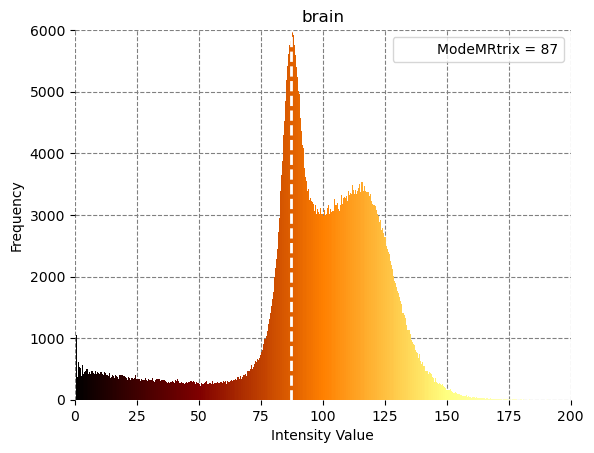

In [4]:
# Set parameters
bins=2000
ylim=6000
Range=(0, 200)

# Mode and histogram of the brain
BB_peak=analyze_nifti_image(flair, mask=flair_brain, bins=bins, title='brain', val2=87, Range=Range, xlim=[0,200], ylim=ylim)


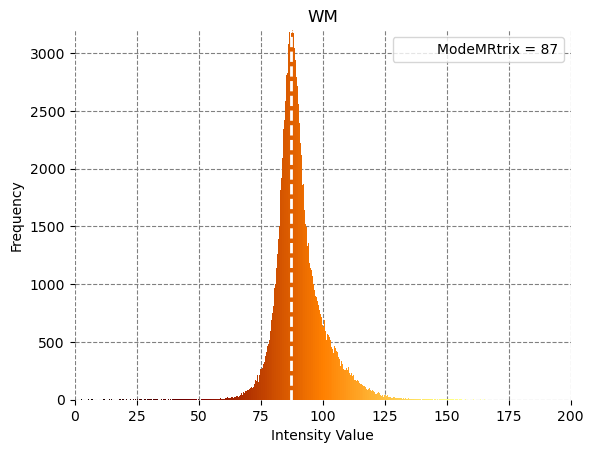

In [5]:
# Mode and histogram of the white matter
WM_peak=analyze_nifti_image(flair, mask=flair_wm, bins=bins, title='WM', val2=87, Range=Range, xlim=[0,200], ylim=3200)


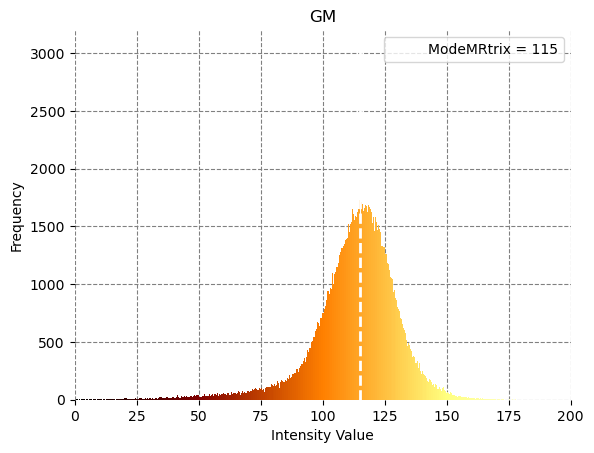

In [6]:
# Mode and histogram of the gray matter
GM_peak=analyze_nifti_image(flair, mask=flair_gm, bins=bins, title='GM', val2=115, Range=Range, xlim=[0,200], ylim=3200)


In [7]:
# Normalize brain image values
def mode_normalization(GM_mode, WM_mode, array):
    ## Mean mode between GM adn wm
    BG=(GM_mode+WM_mode)/2.0
    
    # mode difference
    mode_diff = np.abs(BG - WM_mode)
    # Normalize array
    norm_wm = 100.0 * (array - WM_mode)/(mode_diff)
    norm_gm = 100.0 * (array - GM_mode)/(mode_diff)
    
    return(norm_gm, norm_wm)


In [8]:
# Load flair data
flair_data=nib.load(flair).get_fdata()

# Normalize the data
#flair_gmN, flair_wmN = mode_normalization(GM_peak[1], WM_peak[1], flair_data)

# Normalize the data (MRtrix hist)
flair_gmN, flair_wmN = mode_normalization(115, 87, flair_data)


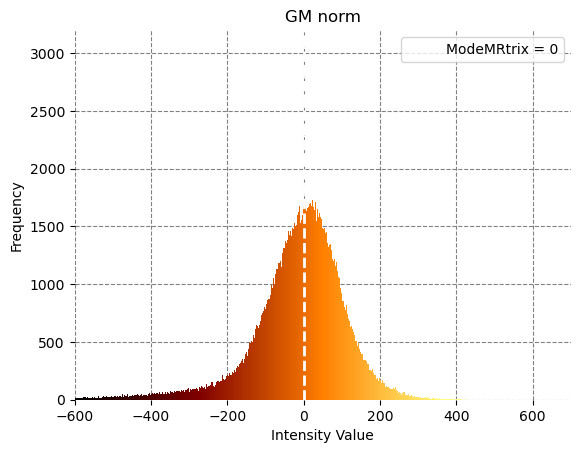

[-821.4285714285714, -821.4285714285714]

In [9]:
xlim=[-600,700]
Range=(-600,700)

# plot the histogram of the normalized GM
# Note: data normalized my the GM mode with center the peak of the GM on zero
analyze_nifti_image(flair_gmN, mask=flair_gm, bins=bins, title='GM norm', val2=0, ylim=3200, xlim=xlim, Range=Range)


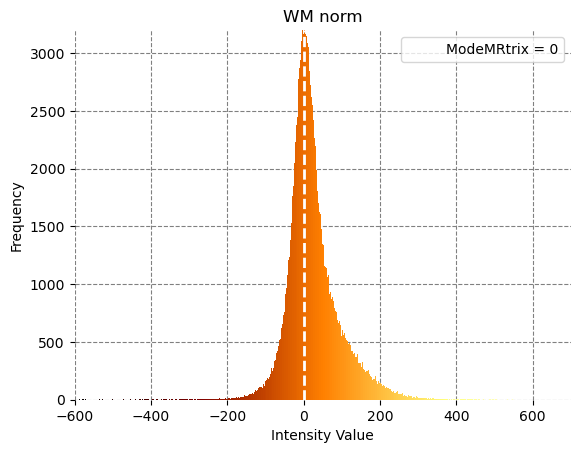

[-621.4285714285714, -621.4285714285714]

In [10]:
# plot the histogram of the normalized WM
# Note: data normalized my the WM mode with center the peak of the WM on zero
analyze_nifti_image(flair_wmN, mask=flair_wm, bins=bins, title='WM norm', val2=0, ylim=3200, xlim=xlim, Range=Range)


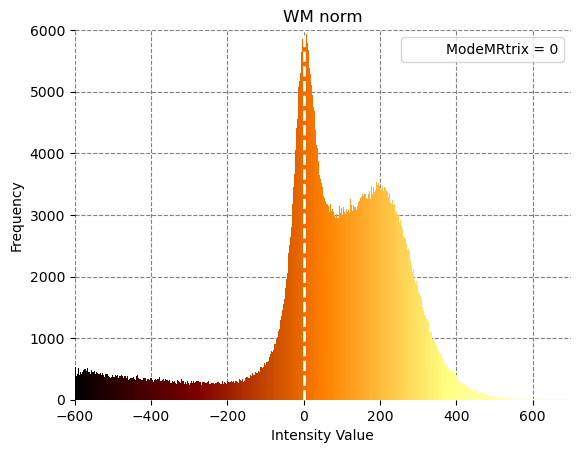

[-606.9338989257812, -606.9338989257812]

In [11]:
# Normalized data
flairN=f'{dirpath}/{idBIDS}_flair_norm.nii.gz'
flairN_data=nib.load(flairN).get_fdata()
analyze_nifti_image(flairN_data, mask=flair_brain, bins=bins, title='WM norm', val2=0, ylim=ylim, xlim=xlim, Range=Range)
